In [ ]:
numpy==1.23.3
pandas==1.4.0
seaborn==0.12.0
scipy==1.9.1
tqdm
matplotlib


In [ ]:
pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    
    

In [ ]:
./trtexec --onnx=output_rt/yolov7.onnx --saveEngine=output_rt/yolov7_fp16.engine --fp16 --workspace=200


In [ ]:
python3 export_onnx.py --weights /opt/nvidia/deepstream/deepstream-6.1/commonFolder/output_rt/yolov7.pt
    

In [1]:
from yolo.yolo_predict import YoloPredict
yp = YoloPredict()

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


第一個模型成功
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

第二個模型成功
第三個模型成功
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

第四個模型成功
[01/15/2023-16:10:25] [TRT] [I] Loaded engine size: 71 MiB
[01/15/2023-16:10:25] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 3246, GPU 10235 (MiB)
[01/15/2023-16:10:25] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +10, now: CPU 3246, GPU 10245 (MiB)
[01/15/2023-16:10:25] [TRT] [W] TensorRT was linked against cuDNN 8.6.0 but loaded cuDNN 8.5.0
[01/15/2023-16:10:25] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +70, now: CPU 0, GPU 70 (MiB)
[01/15/2023-16:10:25] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +1, 

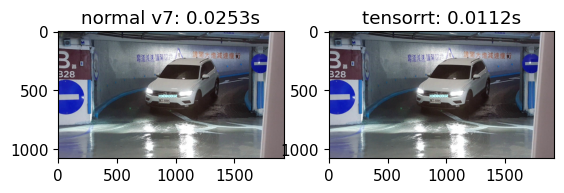

In [16]:
import cv2
import time
%matplotlib inline
import matplotlib.pyplot as plt

img = cv2.imread("./yolo/images/00011.jpg")
t1 = time.time()
img = yp.predict(img)
end = time.time()-t1

# ====================================tensorrt
img2 = cv2.imread("./yolo/images/00011.jpg")
t1 = time.time()
img2 = yp.predict_trt(img2)
end2 = time.time()-t1


plt.figure()
plt.subplot(1,2,1)
plt.title("normal v7: " + str(round(end,4))+"s")
plt.imshow(img)
          
plt.subplot(1,2,2)
plt.title("tensorrt: "+ str(round(end2,4))+"s")
plt.imshow(img2)
plt.show()

In [ ]:
dict_aa = {"aa":1}

In [ ]:
im

0.010909318923950195
0.011199951171875


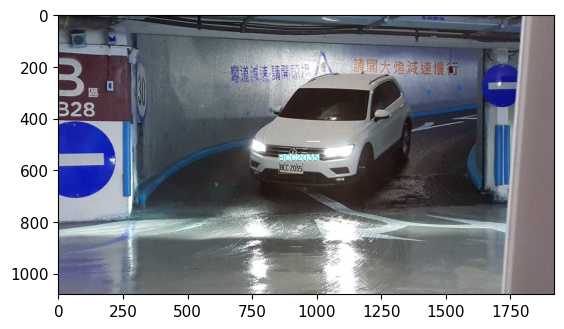

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt


## tensorrt串接


In [4]:
from yolo.utils.general import non_max_suppression, scale_coords, check_img_size

In [5]:
import cv2
import tensorrt as trt
import torch
import numpy as np
from collections import OrderedDict,namedtuple

class TRT_engine():
    def __init__(self, weight) -> None:
        self.imgsz = [416,416]
        self.weight = weight
        self.device = torch.device('cuda:0')
        self.init_engine()

    def init_engine(self):
        # Infer TensorRT Engine
        self.Binding = namedtuple('Binding', ('name', 'dtype', 'shape', 'data', 'ptr'))
        self.logger = trt.Logger(trt.Logger.INFO)
        trt.init_libnvinfer_plugins(self.logger, namespace="")
        with open(self.weight, 'rb') as self.f, trt.Runtime(self.logger) as self.runtime:
            self.model = self.runtime.deserialize_cuda_engine(self.f.read())
        self.bindings = OrderedDict()
        self.fp16 = False
        for index in range(self.model.num_bindings):
            self.name = self.model.get_binding_name(index)
            self.dtype = trt.nptype(self.model.get_binding_dtype(index))
            self.shape = tuple(self.model.get_binding_shape(index))
            self.data = torch.from_numpy(np.empty(self.shape, dtype=np.dtype(self.dtype))).to(self.device)
            self.bindings[self.name] = self.Binding(self.name, self.dtype, self.shape, self.data, int(self.data.data_ptr()))
            if self.model.binding_is_input(index) and self.dtype == np.float16:
                self.fp16 = True
        self.binding_addrs = OrderedDict((n, d.ptr) for n, d in self.bindings.items())
        self.context = self.model.create_execution_context()

    def letterbox(self,im,color=(114, 114, 114), auto=False, scaleup=True, stride=32):
        # Resize and pad image while meeting stride-multiple constraints
        shape = im.shape[:2]  # current shape [height, width]
        new_shape = self.imgsz
        if isinstance(new_shape, int):
            new_shape = (new_shape, new_shape)
        # Scale ratio (new / old)
        self.r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
        if not scaleup:  # only scale down, do not scale up (for better val mAP)
            self.r = min(self.r, 1.0)
        # Compute padding
        new_unpad = int(round(shape[1] * self.r)), int(round(shape[0] * self.r))
        self.dw, self.dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
        if auto:  # minimum rectangle
            self.dw, self.dh = np.mod(self.dw, stride), np.mod(self.dh, stride)  # wh padding
        self.dw /= 2  # divide padding into 2 sides
        self.dh /= 2
        if shape[::-1] != new_unpad:  # resize
            im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(self.dh - 0.1)), int(round(self.dh + 0.1))
        left, right = int(round(self.dw - 0.1)), int(round(self.dw + 0.1))
        self.img = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
        return self.img,self.r,self.dw,self.dh

    def preprocess(self,image):
        self.img,self.r,self.dw,self.dh = self.letterbox(image)
        self.img = self.img.transpose((2, 0, 1))
        self.img = np.expand_dims(self.img,0)
        self.img = np.ascontiguousarray(self.img)
        self.img = torch.from_numpy(self.img).to(self.device)
        self.img = self.img.float()
        return self.img

    def predict(self,img,threshold):
        img = self.preprocess(img)
        self.binding_addrs['images'] = int(img.data_ptr())
        self.context.execute_v2(list(self.binding_addrs.values()))
        nums = self.bindings['num_dets'].data[0].tolist()
        boxes = self.bindings['det_boxes'].data[0].tolist()
        scores =self.bindings['det_scores'].data[0].tolist()
        classes = self.bindings['det_classes'].data[0].tolist()
        num = int(nums[0])
        new_bboxes = []
        for i in range(num):
            if(scores[i] < threshold):
                continue
            xmin = (boxes[i][0] - self.dw)/self.r
            ymin = (boxes[i][1] - self.dh)/self.r
            xmax = (boxes[i][2] - self.dw)/self.r
            ymax = (boxes[i][3] - self.dh)/self.r
            new_bboxes.append([classes[i],scores[i],xmin,ymin,xmax,ymax])
        return new_bboxes

def visualize(img,bbox_array):
    for temp in bbox_array:
        xmin = int(temp[2])
        ymin = int(temp[3])
        xmax = int(temp[4])
        ymax = int(temp[5])
        clas = int(temp[0])
        score = temp[1]
        cv2.rectangle(img,(xmin,ymin),(xmax,ymax), (105, 237, 249), 2)
        img = cv2.putText(img, "class:"+str(clas)+" "+str(round(score,2)), (xmin,int(ymin)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (105, 237, 249), 1)
    return img

trt_engine = TRT_engine("./output_rt/engine/best1.engine")
trt_engine2 = TRT_engine("./output_rt/engine/best2.engine")
# trt_engine = TRT_engine("./best1.engine")


[01/15/2023-13:48:51] [TRT] [I] Loaded engine size: 71 MiB
[01/15/2023-13:48:51] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 3259, GPU 10235 (MiB)
[01/15/2023-13:48:51] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +1, GPU +10, now: CPU 3260, GPU 10245 (MiB)
[01/15/2023-13:48:51] [TRT] [W] TensorRT was linked against cuDNN 8.6.0 but loaded cuDNN 8.5.0
[01/15/2023-13:48:51] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +70, now: CPU 0, GPU 70 (MiB)
[01/15/2023-13:48:51] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 3188, GPU 10237 (MiB)
[01/15/2023-13:48:51] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 3188, GPU 10245 (MiB)
[01/15/2023-13:48:51] [TRT] [W] TensorRT was linked against cuDNN 8.6.0 but loaded cuDNN 8.5.0
[01/15/2023-13:48:51] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +26, now: CPU 0, GPU 96 (MiB)
[0

/tmp/ipykernel_32539/939428214.py:24: DeprecationWarning: Use get_tensor_name instead.
  self.name = self.model.get_binding_name(index)
/tmp/ipykernel_32539/939428214.py:25: DeprecationWarning: Use get_tensor_dtype instead.
  self.dtype = trt.nptype(self.model.get_binding_dtype(index))
/tmp/ipykernel_32539/939428214.py:26: DeprecationWarning: Use get_tensor_shape instead.
  self.shape = tuple(self.model.get_binding_shape(index))
/tmp/ipykernel_32539/939428214.py:29: DeprecationWarning: Use get_tensor_mode instead.
  if self.model.binding_is_input(index) and self.dtype == np.float16:


In [26]:
def predict_yolo_rt(rt_infer, origin_img):
    output = {
        "box":list(),
        "image":list(),
    }
    pred = rt_infer.predict(origin_img,threshold=0.5)
    pred = torch.Tensor(pred)
    pred = [pred[pred[:, 2].sort(descending=True)[1]]]
    
    for i, det in enumerate(pred):
        if len(det):
            for conf, cls, *xyxy in reversed(det):
                c1, c2 = (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3]))
                output["box"].append([c1, c2])
                output["image"].append(origin_img[c1[1]:c2[1], c1[0]:c2[0]])

    return output

In [23]:
import time
img = cv2.imread("./yolo/images/00011.jpg")
t1 = time.time()

results = trt_engine.predict(img,threshold=0.5)
crop_output = predict_yolo_rt(trt_engine, img)
print(time.time()-t1)

tensor([[  0.00000,   0.95703, 854.42310, 564.80768, 949.03845, 614.42310]])
0.01360321044921875


In [43]:
t1 = time.time()
crop_output = predict_yolo_rt(trt_engine, img)
if crop_output["box"] != []:
    labels = list()
    for index, crop_img in enumerate(crop_output["image"]):
        if index > 6:
            break
        seg_output = predict_yolo_rt(trt_engine2, crop_img)

        # predict the word
        rec_output = ""
        for seg_img in seg_output["image"]:
            rec_output += yp.predict_rec(seg_img)
        labels.append(rec_output)
print(time.time()-t1)
print(labels)

0.012116432189941406
['BCC2035']


In [32]:
for crop_box, label in zip(crop_output["box"], labels):
    x1, y1, x2, y2 = crop_box[0][0], crop_box[0][1], crop_box[1][0], crop_box[1][1]

    fontFace = cv2.FONT_HERSHEY_COMPLEX
    fontScale = 1e-3 * img.shape[0]
    thickness = 1
    labelSize = cv2.getTextSize(label, fontFace, fontScale, thickness)
    _x2 = x1 + labelSize[0][0]  # topright x of text
    _y2 = y1 - labelSize[0][1]  # topright y of text
    cv2.rectangle(img, (x1, y1), (x2, y2), (200, 255, 255), 1)

    cv2.rectangle(img, (x1, y1), (_x2, _y2), (200, 255, 255), cv2.FILLED)
    if len(label) > 8:
        label = label[:9]
    cv2.putText(img,
                "{}".format(label),
                (x1, y1),
                cv2.FONT_HERSHEY_SIMPLEX,
                fontScale,
                (0, 0, 0),
                thickness)

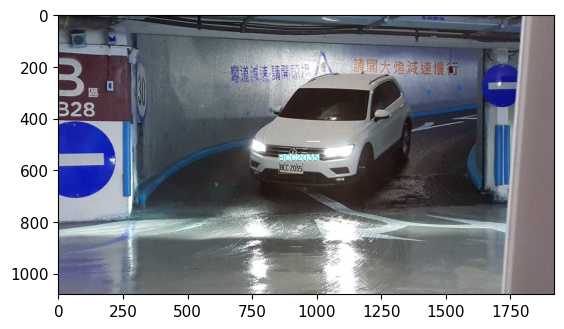

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()